# Unified Post-Processing in DeePTB

This tutorial demonstrates the usage of the unified post-processing interface in DeePTB. The new `TBSystem` class acts as a central hub for managing your tight-binding model and structure, providing streamlined access to properties like Band Structure and Density of States (DOS).

## key Features
- **Centralized Control**: `TBSystem` manages both the atomic structure (`AtomicData`) and the Hamiltonian model (`HamiltonianCalculator`).
- **Property Accessors**: Intuitive access to properties via `system.band`, `system.dos`, etc.
- **Flexible Configuration**: Stateful configuration for K-paths and K-meshes.
- **Integration**: Seamlessly works with DeePTB models and ASE structures.

## 1. Setup and Initialization

First, we define the paths to our model checkpoint (`.pth`) and the atomic structure file (e.g., `POSCAR` or `.vasp`).

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from dptb.postprocess.unified.system import TBSystem

# Define paths (Adjust to your local environment)
root_dir = os.path.abspath("../ToW90_PythTB") 
model_path = os.path.join(root_dir, "models", "nnsk.ep20.pth")
struct_path = os.path.join(root_dir, "silicon.vasp")
model_non_north = "./nnsk.non_orth.pth"


TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
Pybinding is not installed. Please install it via `pip install pybinding`


### Initialize TBSystem

We instantiate `TBSystem` by providing the data (structure) and the calculator (model). This automatically loads the model and prepares the system for calculation.

In [32]:
# Initialize the system with orthogonal and non-orthogonal TB models
tbsys = TBSystem(data=struct_path, calculator=model_path)
tbsys2 = TBSystem(data=struct_path, calculator=model_non_north)

print("TBSystem Initialized.")
# You can access the underlying ASE atoms object
print(f"Atoms: {tbsys.atoms}")
print(f"Atoms: {tbsys2.atoms}")

The model option atomic_radius in nnsk is not defined in input model_options, set to v1.


TBSystem Initialized.
Atoms: Atoms(symbols='Si2', pbc=True, cell=[[0.0, 2.71499984016137, 2.71499984016137], [2.71499984016137, 0.0, 2.71499984016137], [2.71499984016137, 2.71499984016137, 0.0]])
Atoms: Atoms(symbols='Si2', pbc=True, cell=[[0.0, 2.71499984016137, 2.71499984016137], [2.71499984016137, 0.0, 2.71499984016137], [2.71499984016137, 2.71499984016137, 0.0]])


## 2. Band Structure Calculation

The `tbsys.band` accessor manages band structure calculations. You first configure the K-path and then compute the bands.

### Configure K-Path
We typically use the high-symmetry points. Here we define a path G-X-U-K-G-L-W-X using the `abacus` method convention.

In [37]:
kpath_config = {
    "method": "abacus",
    "kpath": [
        [0.000, 0.000, 0.000, 50], # G
        [0.500, 0.000, 0.500, 50], # X
        [0.625, 0.250, 0.625, 1],  # U
        [0.375, 0.375, 0.750, 50], # K
        [0.000, 0.000, 0.000, 50], # G 
        [0.500, 0.500, 0.500, 50], # L
        [0.500, 0.250, 0.750, 50], # W
        [0.500, 0.000, 0.500, 1]   # X
    ],
    "klabels": ["G", "X", "X/U", "K", "G", "L", "W", "X"]
}

# Set the configuration
tbsys.band.set_kpath(**kpath_config)
tbsys2.band.set_kpath(**kpath_config)

### Compute and Plot
Once configured, call `compute()` to run the model and get eigenvalues. The result is a `BandStructureData` object which supports plotting.

In [38]:
tbsys.set_electrons({'Si':4})
tbsys.get_efermi(kmesh=[5,5,5])
tbsys2.set_electrons({'Si':4})
tbsys2.get_efermi(kmesh=[5,5,5])
print(f"Fermi Level (Orthogonal): {tbsys.efermi} eV")
print(f"Fermi Level (Non-Orthogonal): {tbsys2.efermi} eV")

eig_solver is not set, using default 'torch'.
eig_solver is not set, using default 'torch'.


Fermi Level (Orthogonal): -8.566754648927265 eV
Fermi Level (Non-Orthogonal): -4.143006716568811 eV


eig_solver is not set, using default 'torch'.
eig_solver is not set, using default 'torch'.


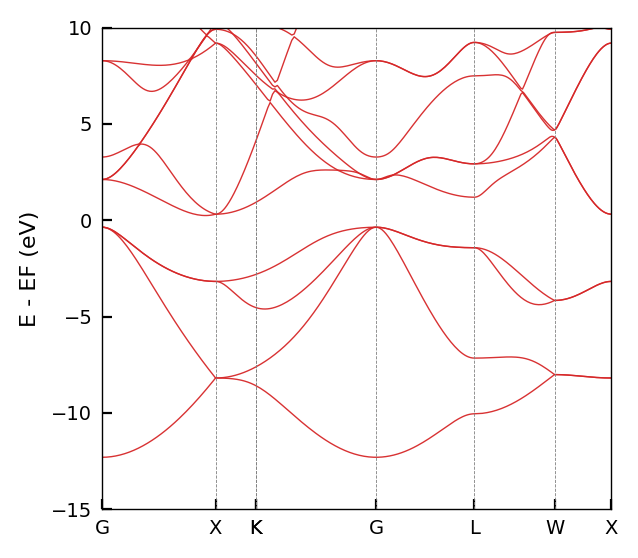

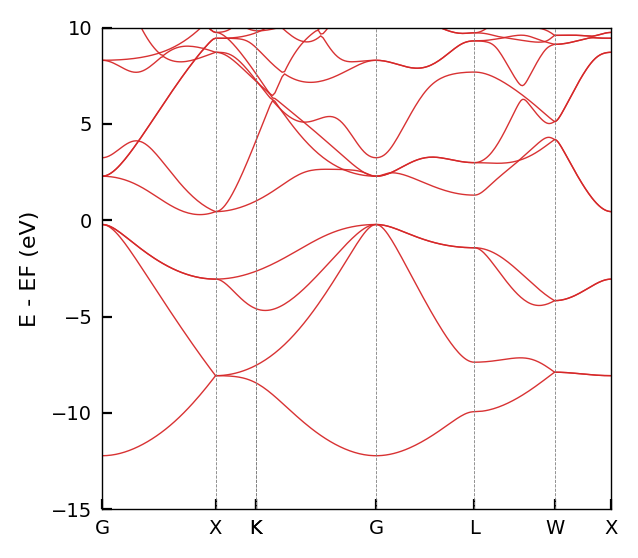

In [41]:
# Compute bands
# Compute bands with rough Fermi estimation
bs_data = tbsys.band.compute()
bs_data2 = tbsys2.band.compute()

# Plot the result
tbsys.band.plot(emin=-15, emax=10, filename="silicon_bands.png")
tbsys2.band.plot(emin=-15, emax=10, filename="silicon_bands_non_orth.png")

In [42]:
bs_data2.high_sym_kpoints

array([0.        , 0.18416207, 0.2492732 , 0.2492732 , 0.44460658,
       0.60409561, 0.73431786, 0.8263989 ])

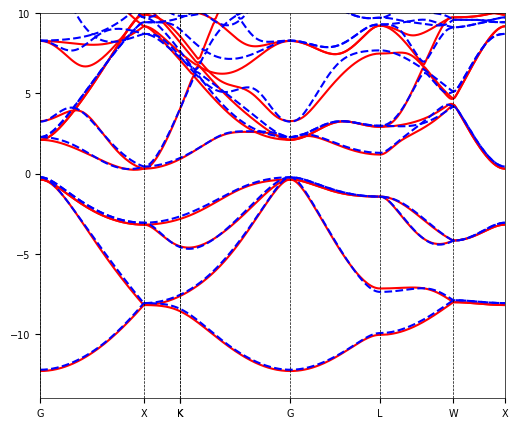

In [54]:
# Compare band structures
plt.figure(figsize=(6,5))
plt.plot(bs_data.xlist,bs_data.eigenvalues[:,:]-tbsys.efermi,'r-')
plt.plot(bs_data2.xlist,bs_data2.eigenvalues[:,:]-tbsys2.efermi,'b--')
for i in bs_data2.high_sym_kpoints:
    plt.axvline(x=i, color='k', linestyle='--', linewidth=0.5)
plt.xticks(bs_data.high_sym_kpoints, bs_data.labels)
plt.ylim(-14,10)
plt.xlim(0,bs_data.xlist[-1])
plt.xlabel
plt.show()

## 3. Density of States (DOS)

Similarly, the `tbsys.dos` accessor handles DOS and Projected DOS (PDOS).

### Configure K-Mesh and Energy Range
We set a uniform K-point mesh (e.g., 8x8x8) and define the energy range and smearing.

In [55]:
# 1. Define K-Mesh (eagerly generates k-points)
tbsys.dos.set_kpoints(kmesh=[35, 35, 35], is_gamma_center=True)
# 2. Configure DOS parameters
tbsys.dos.set_dos_config(
    erange=[-10, 10],
    npts=500,
    sigma=0.1, 
    pdos=True  # Calculate Projected DOS as well
)

tbsys2.dos.set_kpoints(kmesh=[35, 35, 35], is_gamma_center=True)
# 2. Configure DOS parameters
tbsys2.dos.set_dos_config(
    erange=[-10, 10],
    npts=500,
    sigma=0.1, 
    pdos=True  # Calculate Projected DOS as well
)

### Compute and Plot DOS
Compute the DOS. If `pdos=True`, this might take slightly longer as it computes eigenvectors.

Total DOS shape: (500,)
PDOS shape: (500, 18) (Energy Points, Orbitals)


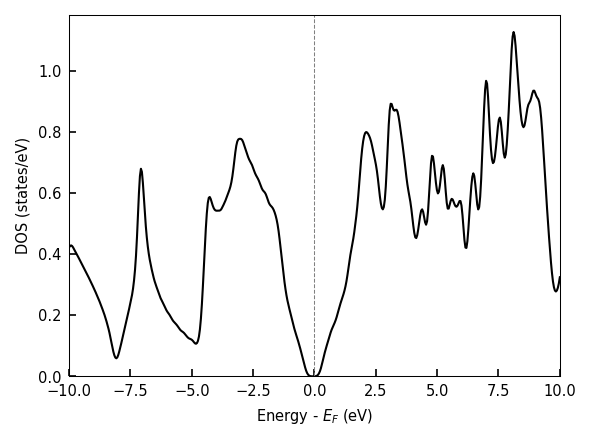

In [56]:
# Compute DOS with accurate Fermi calculation
dos_data = tbsys.dos.compute()
print(f"Total DOS shape: {dos_data.total_dos.shape}")
if dos_data.pdos is not None:
    print(f"PDOS shape: {dos_data.pdos.shape} (Energy Points, Orbitals)")

# Plot DOS and PDOS
tbsys.dos.plot(plot_pdos=False, filename="silicon_dos.png")

Total DOS shape: (500,)
PDOS shape: (500, 18) (Energy Points, Orbitals)


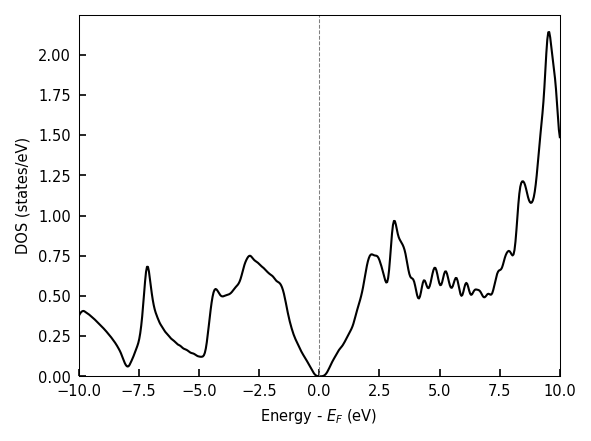

In [57]:
# Compute DOS with accurate Fermi calculation
dos_data2 = tbsys2.dos.compute()
print(f"Total DOS shape: {dos_data2.total_dos.shape}")
if dos_data2.pdos is not None:
    print(f"PDOS shape: {dos_data2.pdos.shape} (Energy Points, Orbitals)")

# Plot DOS and PDOS
tbsys2.dos.plot(plot_pdos=False, filename="silicon_dos.png")

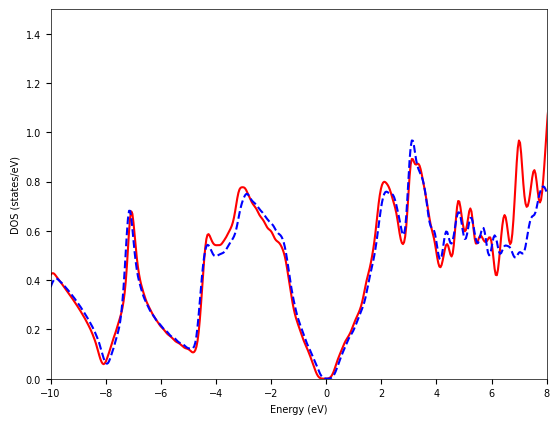

In [69]:
dos_data2.energy_grid
plt.plot(dos_data.energy_grid-tbsys.efermi,dos_data.total_dos,'r-')
plt.plot(dos_data2.energy_grid-tbsys2.efermi,dos_data2.total_dos,'b--')
plt.xlim(-10,8)
plt.ylim(0,1.5)

plt.xlabel("Energy (eV)")
plt.ylabel("DOS (states/eV)")
plt.show()

## 4. Advanced Usage: Direct Hamiltonian Access

You can also access the underlying `HamiltonianCalculator` to get raw Hamiltonian matrices $H(k)$ or $H(R)$.

In [ ]:
# Get H(k) at specific k-points
k_points = [[0, 0, 0], [0.5, 0.5, 0.5]] # G, L
hk, sk = tbsys.calculator.get_hk(tbsys.data, k_points=k_points)

print("Hamiltonian H(k) at G and L:")
print(hk.shay任意若与i哦婆婆iu一天热武器·强啊ZA区·pe) # Expected: [2, Norb, Norb]

Hamiltonian H(k) at G and L:
torch.Size([2, 18, 18])


In [10]:
# Get Real-Space Hopping H(R)
hr_blocks, sr_blocks = tbsys.calculator.get_hr(tbsys.data)

print("Number of hopping blocks:", len(hr_blocks))
# hr_blocks is a dictionary or tensor map of hopping matrices

Number of hopping blocks: 36


In [1]:
import os
import torch
import matplotlib.pyplot as plt
from dptb.postprocess.unified.system import TBSystem

# Define paths (Adjust to your local environment)
root_dir = os.path.abspath("../e3") 
model_path = os.path.join(root_dir, "ref_model", "nnenv.ep1474.pth")
struct_path = os.path.join(root_dir, "data","Si64.vasp")
overlap =  os.path.join(root_dir, "data", "Si64.0", "overlaps.h5")


TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
Pybinding is not installed. Please install it via `pip install pybinding`


In [2]:
# Initialize the system with orthogonal and non-orthogonal TB models
tbsys = TBSystem(data=struct_path, calculator=model_path,override_overlap=overlap)
print("TBSystem Initialized.")
# You can access the underlying ASE atoms object
print(f"Atoms: {tbsys.atoms}")


override_overlap is enabled while model contains overlap, override_overlap will be used.


TBSystem Initialized.
Atoms: Atoms(symbols='Si64', pbc=True, cell=[10.887404441833496, 10.887404441833496, 10.887404441833496])


In [3]:
kpath_config = {
        "method":"abacus",
        "kpath":[[0.0000000000,   0.0000000000,   0.0000000000,   20],   
                [0.5000000000,   0.0000000000,   0.0000000000,   1],               
                [0.0000000000,   0.5000000000,   0.0000000000,   20],    
                [0.0000000000,   0.0000000000,   0.0000000000,   20],     
                [0.0000000000,   0.0000000000,   0.5000000000,   1],    
                [-0.5000000000,  -0.5000000000,   0.5000000000,   20],                
                [0.0000000000,   0.0000000000,   0.0000000000,   20],               
                [0.0000000000,   -0.5000000000,   0.5000000000,   1 ],
                [-0.5000000000,   0.0000000000,   0.5000000000, 20],
                [0.0000000000, 0.0000000000, 0.0000000000, 20],
                [0.5000000000, -0.5000000000, 0.0000000000, 1]
                ],
        "klabels":["G","X","Y","G","Z","R_2","G","T_2","U_2","G","V_2"],
}
# Set the configuration
tbsys.band.set_kpath(**kpath_config)

/Users/aisiqg/Desktop/work/github/DeePTB/.venv/lib/python3.10/site-packages/torch/nested/__init__.py:107: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:180.)
  return torch._nested_tensor_from_tensor_list(ts, dtype, None, device, None)


In [4]:
tbsys.set_electrons({'Si':4})
tbsys.get_efermi(kmesh=[5,5,5])
print(f"Fermi Level: {tbsys.efermi} eV")

eig_solver is not set, using default 'torch'.


Fermi Level: 7.716914722357162 eV


eig_solver is not set, using default 'torch'.


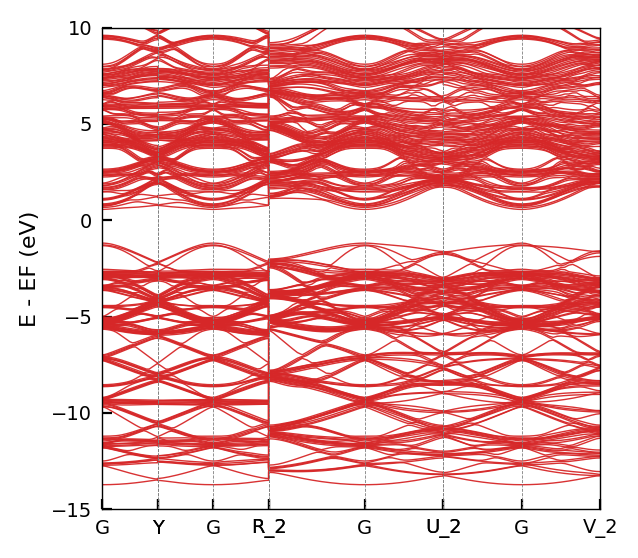

In [ ]:
# Compute bands
# Compute bands with rough Fermi estimation
bs_data = tbsys.band.compute()
# Plot the result
tbsys.band.plot(emin=-15, emax=10, filename="band.png")
